# HMM Forecasting Walkthrough
### This notebook shows the step by step process of generating hmm forecasts along with forecast validation using simulated data.



## Setup
Load hmmTMB and other packages

In [2]:
library(devtools)
library(ggridges)
set.seed(1)

Loading required package: usethis



In [3]:

load_all("../../../hmmTMB")

ℹ Loading hmmTMB
Loading required package: R6

Loading required package: mgcv

Loading required package: nlme

This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.

Loading required package: TMB

Loading required package: ggplot2



## Generate Data
Use the true model defined in true_mod.hmm to set the model functions.
Set arbitrary fixed effect coefficients.

In [4]:
# Simulate data -----------------------------------------------------------

# number of time steps
n <- 1000

# Generate training data with random covariates
empty <- data.frame(
  ID = 1, 
  count = rep(NA, n),
  size = rep(NA, n),
  covariate_1 = rnorm(n, mean = 0, sd = 1),
  covariate_2 = runif(n, min = -1, max = 1),
  covariate_3 = sample(c(-1, 0, 1), n, replace = TRUE)
)

# create true model
true_mod <- HMM$new(file = "forecast_true_mod.hmm")

# Create a list of random integers for the hidden Markov model coefficients
random_coeff_fe_obs <- replicate(
  length(true_mod$coeff_list()$coeff_fe_obs),
  sample(c(0.9, 1, 1.1, 1.2), 1, replace = TRUE)
)
random_coeff_fe_hid <- replicate(
  length(true_mod$coeff_list()$coeff_fe_hid),
  sample(c(0.9, 1, 1.1, 1.2), 1, replace = TRUE)
)

# Update the coefficients of the hidden Markov model with the random values
true_mod$obs()$update_coeff_fe(coeff_fe = random_coeff_fe_obs)
true_mod$hid()$update_coeff_fe(coeff_fe = random_coeff_fe_hid)

# View the model parameters
true_mod$coeff_list()



count.rate.state1.(Intercept),0.9
count.rate.state1.covariate_1,1.2
count.rate.state2.(Intercept),1.0
count.rate.state2.covariate_1,1.0
size.mean.state1.(Intercept),0.9
size.mean.state1.covariate_2,1.1
size.mean.state2.(Intercept),1.1
size.mean.state2.covariate_2,0.9
size.sd.state1.(Intercept),1.1
size.sd.state2.(Intercept),0.9
S1>S2.(Intercept),1.2


Simulating states... 100%
Simulating count... 100%
Simulating size... 100%


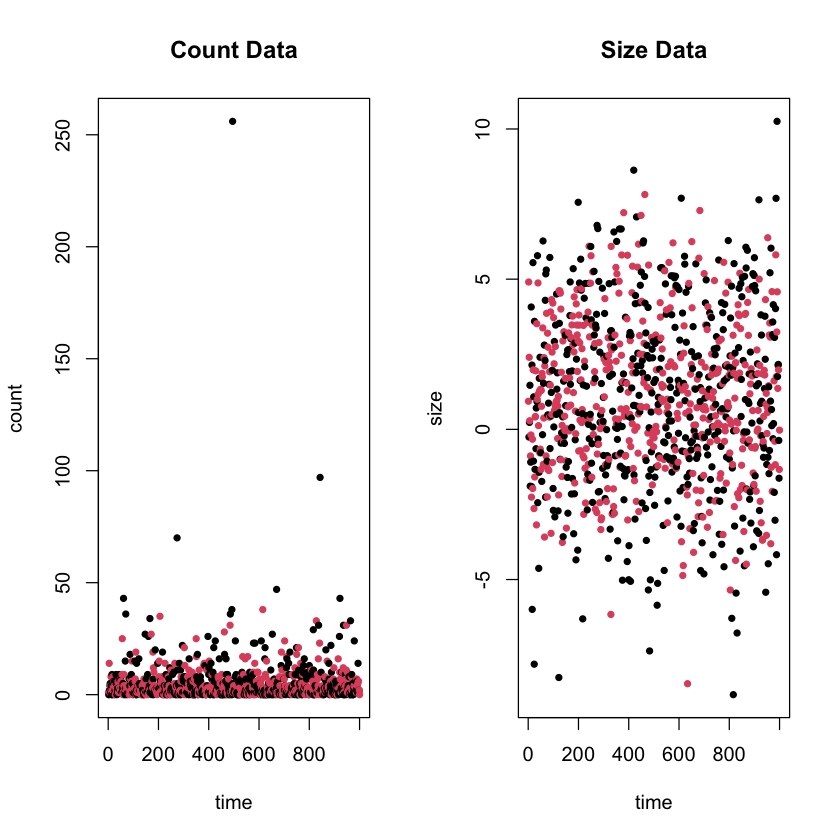

In [5]:
# simulate from true model
training <- true_mod$simulate(n, data = empty)

# update data in true_mod with dat
true_mod$obs()$update_data(training)

# plot data
par(mfrow = c(1, 2)) # set outer margins to 0
plot(training$count, pch = 20, xlab = "time", ylab = "count", col = attr(training, "state"), main = "Count Data")
plot(training$size, pch = 20, xlab = "time", ylab = "size", col = attr(training, "state"), main = "Size Data")
par(mfrow = c(1, 1))

## Fit the model 
Fit a model using the model definition and starting parameters defined by mod.hmm

In [6]:
# Fit model ------------------------------------------------------------

# create model to fit 
mod <- HMM$new(file = "forecast_mod.hmm")

# suggest better starting parameters
ini <- mod$suggest_initial()

# set to new starting parameters (or you could edit the specification file)
mod$obs()$update_par(ini)

# fit model
mod$fit(silent = TRUE)

Check that the model has converged and fit properly

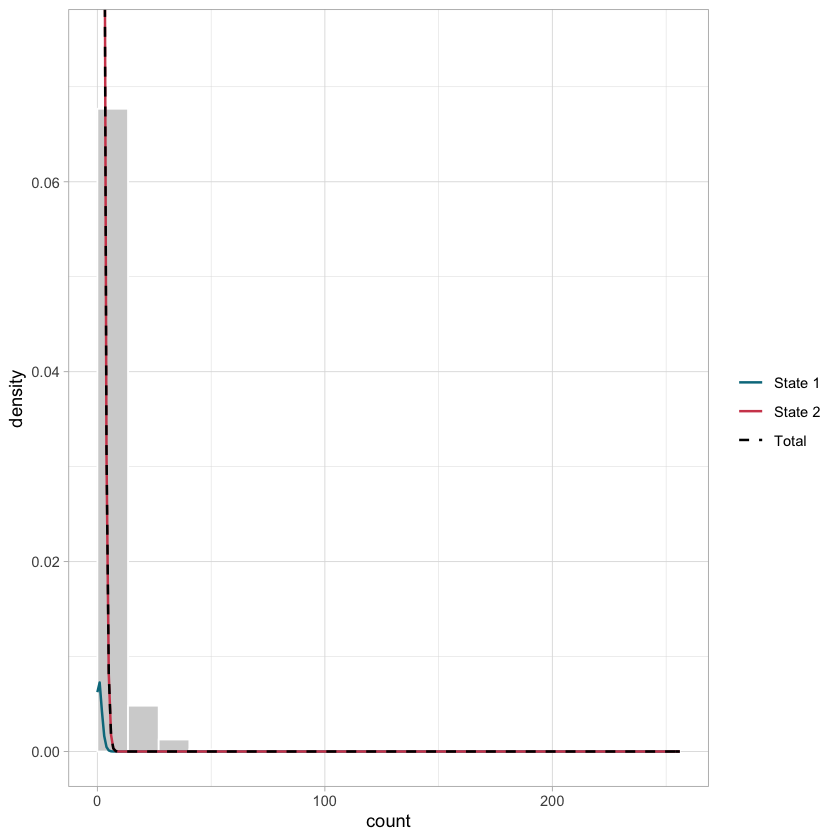

Computing CDFs... done
Computing residuals for count ... done
Computing residuals for size ... done


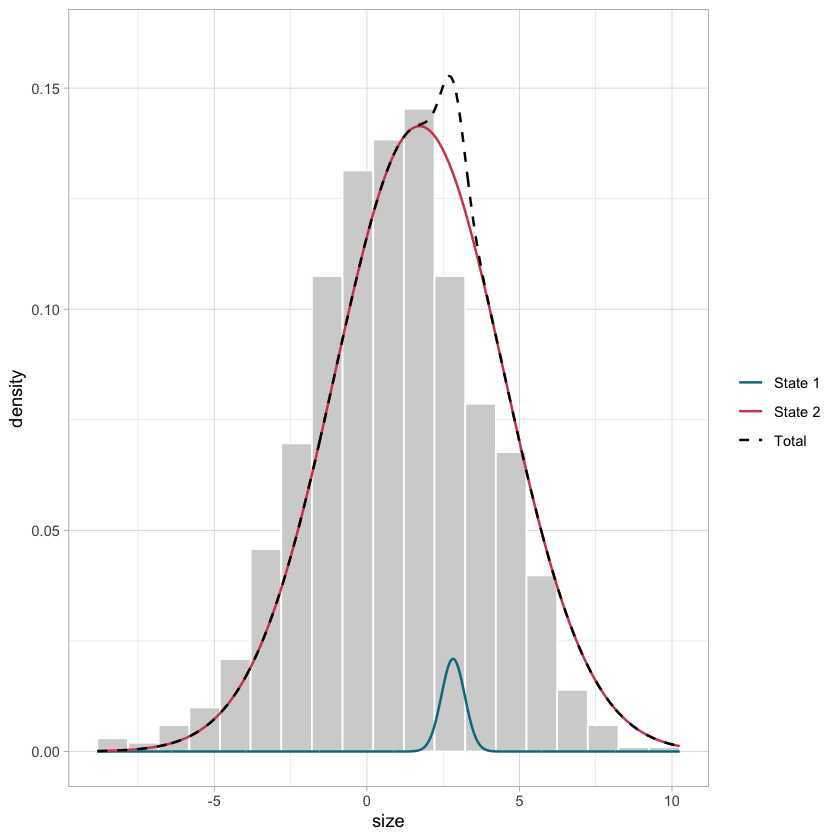

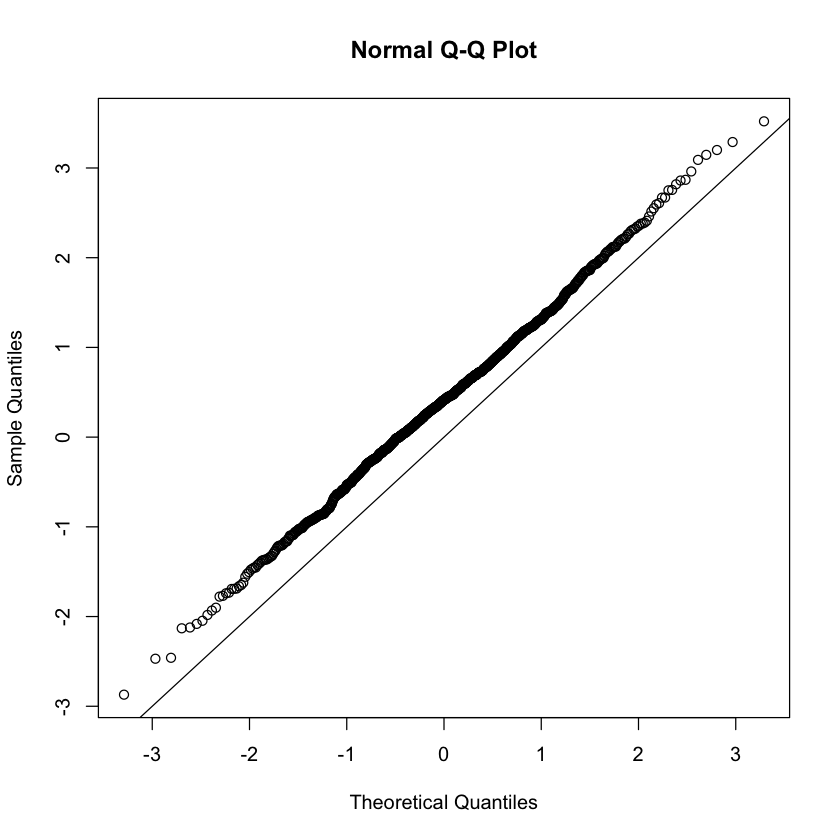

In [7]:
par(mfrow = c(1, 2))
mod$plot_dist("count")
mod$plot_dist("size")
par(mfrow = c(1, 1))

pr <- mod$pseudores()

qqnorm(pr$count)
abline(0, 1)


## Forecasting
Use the fitted model to generate a probability distribution for each future state.

Set the number of future time steps to predict.
Calculate the parameter values at future time steps accounting for covariates using the predict method

In [8]:
# Set number of observations to predict
n <- 10

# Create new data for prediction, optionally with covariates
forecasts <- data.frame(
  ID = 1, 
  count = rep(NA, n),
  size = rep(NA, n),
  covariate_1 = rnorm(n, mean = 0, sd = 1),
  covariate_2 = runif(n, min = -1, max = 1),
  covariate_3 = sample(c(-1, 0, 1), n, replace = TRUE)
)

forecasts

ID,count,size,covariate_1,covariate_2,covariate_3
<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>
1,NA,NA,-0.27225030,0.2506252,1
1,NA,NA,-0.71720824,0.8678033,0
1,NA,NA,-0.19532618,-0.2374188,1
1,NA,NA,1.31326420,0.5469202,0
1,NA,NA,0.01268243,0.3950817,-1
1,NA,NA,-1.12421159,0.8369966,-1
1,NA,NA,0.85662803,-0.7556111,1
1,NA,NA,0.31418212,0.7315667,-1
1,NA,NA,0.33667190,0.7975774,1


In [9]:
# Predict parameters for each future time step accounting for covariates
obs_par_forecast <- mod$predict("obspar", newdata = forecasts)
tpm_forecast <- mod$predict("tpm", newdata = forecasts)

# Set the forecasted parameters in the forecasts object
attr(forecasts, "obs_par") <- mod$predict("obspar", newdata = forecasts)
attr(forecasts, "tpm") <- mod$predict("tpm", newdata = forecasts)

# Print the first three time steps of the forecast
cat("Observation Parameter Forecast:\n")
print(obs_par_forecast[1, ,1:3])
cat("\nTransition Probability Matrix Forecast:\n")
print(tpm_forecast[, ,1:3])

Observation Parameter Forecast:
            [,1]     [,2]     [,3]
state 1 1.614333 1.070022 1.733282
state 2 1.938500 1.166783 2.116320

Transition Probability Matrix Forecast:
, , 1

           state 1   state 2
state 1 0.16877528 0.8312247
state 2 0.05528666 0.9447133

, , 2

            state 1   state 2
state 1 0.360825935 0.6391741
state 2 0.009623971 0.9903760

, , 3

           state 1   state 2
state 1 0.16877528 0.8312247
state 2 0.05528666 0.9447133



#### Hidden State Forecast
Forecast the hidden states based on the TPM matrix.
Use the last hidden state of the fitted model as the starting point.

TODO: The starting distribution should be a variable that can either be set as the last fitted state distribution, or the stationary distribution or a custom starting point.

In [10]:
# Hidden State Forecasting -------------------------------------------------------------
# Get starting distribution of hidden states
last_state_distribution <- tail(mod$state_probs(), 1)
last_training_tpm <- mod$hid()$tpm(nrow(mod$obs()$data()))[, , 1]

# Initialize the forecast matrix to store results
hidden_state_forecast <- array(NA, dim = c(mod$hid()$nstates(), nrow(forecasts)))

# Set the initial distribution
hidden_state_forecast[, 1] <- last_state_distribution %*% last_training_tpm

# Loop through the remaining time steps
for (t in 2:nrow(forecasts)) {
  hidden_state_forecast[, t] <- hidden_state_forecast[, t - 1] %*% tpm_forecast[, , t-1]
}

# Set hidden_state_forecast as an attribute of forecasts
attr(forecasts, "hidden_state_forecast") <- hidden_state_forecast

# Print the forecasted hidden state probabilities
dim(hidden_state_forecast)
print(hidden_state_forecast[ , 1:3])

[1]  2 10

            [,1]       [,2]       [,3]
[1,] 0.009624429 0.05637892 0.02942436
[2,] 0.990375571 0.94362108 0.97057564


#### Check Dimensions

Get list of observation distributions in the case were the model is predicting multiple outputs.

Check that all the dimensions match.

In [11]:
obs_dists <- mod$obs()$dists()

length(obs_dists)
dim(obs_par_forecast)
dim(hidden_state_forecast)

# Check dimensions
if (dim(obs_par_forecast)[2] != dim(hidden_state_forecast)[1]) {
  stop("Error: Number of hidden states in obs_par_forecast does not match the number of hidden states in hidden_state_forecast.")
}
if (dim(obs_par_forecast)[3] != dim(hidden_state_forecast)[2]) {
  stop("Error: Number of forecasts in obs_par_forecast does not match the number of forecasts in hidden_state_forecast.")
}

cat("Dimensions checks passed.\n")


[1] 2

[1]  3  2 10

[1]  2 10

Dimensions checks passed.


In [12]:
# Get hidden state covariate names
hid_covariates <- unique(unlist(lapply(true_mod$hid()$formulas(), all.vars)))

# Get emission variable names
emission_vars <- colnames(true_mod$obs()$obs_var())

obs_covariates <- c()
for (emission_var in emission_vars) {
  for (attribute in names(true_mod$obs()$formulas()[[emission_var]])) {
    obs_covariates <- c(
      obs_covariates,
      unlist(lapply(true_mod$obs()$formulas()[[emission_var]][[attribute]], all.vars))
    )
  }
}
obs_covariates <- unique(obs_covariates)

# Print results
cat("Observation Model Covariates:", obs_covariates, "\n")
cat("Hidden State Model Covariates:", hid_covariates, "\n")
cat("Emission Variables:", emission_vars, "\n")

Observation Model Covariates: covariate_1 covariate_2 
Hidden State Model Covariates: covariate_3 
Emission Variables: count size 


### Generate Forecasts

1.  **Defining Evaluation Points:** Establishing a range of x values at which the forecast probability density will be evaluated.
2.  **Iterating Through Dimensions and Time:** Looping through each output dimension and each time step in the forecast horizon.
3.  **Calculating Weighted Probabilities:**  For each time step, the forecast probability is computed as a weighted sum of the probability density of each hidden state multiplied by the probability of being in that hidden state.

In [13]:
x_count <- 100
nstates <- mod$hid()$nstates()
# Requires mod object
# requires forecasts dataframe

preset_x_vals <- list(
  'count' = seq(0, 100, by = 1)
) 

for (dimension in emission_vars) {

  # Step 1 - generate x values based on pm 10% of the training data range
  if (exists("preset_x_vals") && (dimension %in%
      names(preset_x_vals)) && !is.null(preset_x_vals[[dimension]])) {
    x_vals <- preset_x_vals[[dimension]]
    attr(forecasts, paste0(dimension, "_x_vals")) <- x_vals
  } else {
    max_range <- max(mod$obs()$data()[[dimension]], na.rm = TRUE)*1.1
    min_range <- min(mod$obs()$data()[[dimension]], na.rm = TRUE)*0.9
    x_vals <- seq(min_range, max_range, length.out = x_count)
    attr(forecasts, paste0(dimension, "_x_vals")) <- x_vals
  }


  # Step 2 - Get distribution function and parameters list
  obs_dists <- mod$obs()$dists()[[dimension]]

  pdf_params <- paste0(dimension, ".", names(formals(obs_dists$pdf())))
  model_params <- names(obs_par_forecast[ , 1, 1])
  current_params <- intersect(pdf_params, model_params)

  # Step 3 - Loop through the forecasted parameters and calculate the weighted
  # pdf
  forecast_pdfs <- array(NA, dim = c(length(x_vals), nrow(forecasts)))
  for (n in seq_len(nrow(forecasts))) {
    pdf_matrix <- sapply(seq_len(nstates), function(s) {
      obs_dists$pdf_apply(
        x = x_vals,
        par = setNames(
          obs_par_forecast[current_params, s, n], 
          obs_dists$parnames()
        )
      )
    })
    # Normalize the probabilities
    forecast_pdfs[, n] <- as.vector(pdf_matrix %*% hidden_state_forecast[, n])
    forecast_pdfs[, n] <- forecast_pdfs[, n] / sum(forecast_pdfs[, n])
  }
  # Step 4 - Save the pdfs to the forecasts object
  attr(forecasts, paste0(dimension, "_pdfs")) <- forecast_pdfs
}


### Plot the forecasted PDFs

Generate a ridge plot to show the probability distribution for each time step.
The plot shows every second time step to help declutter the plot.

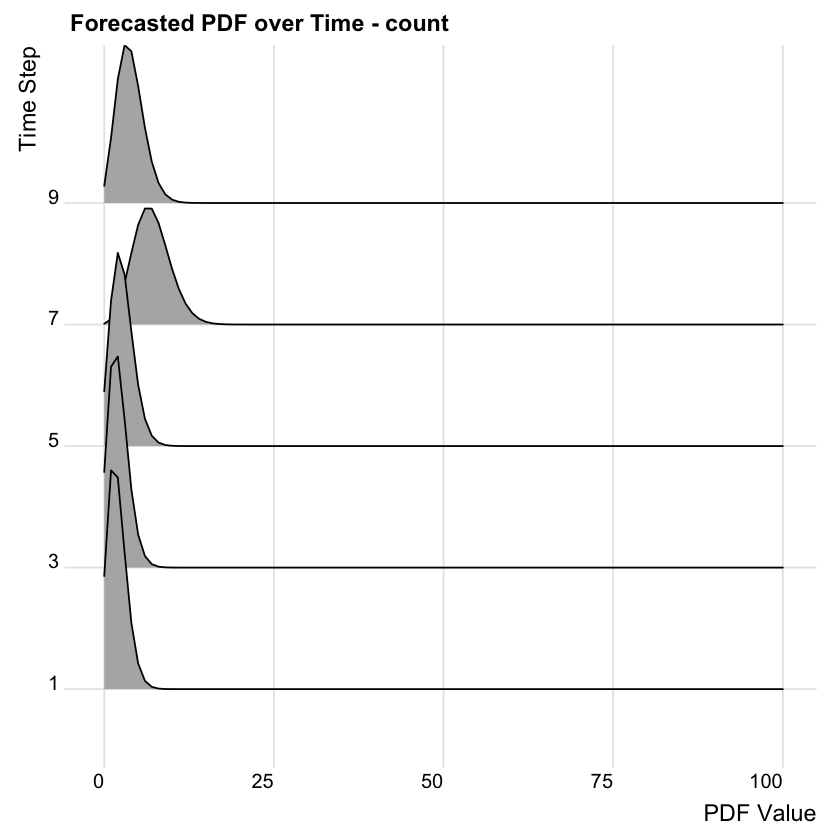

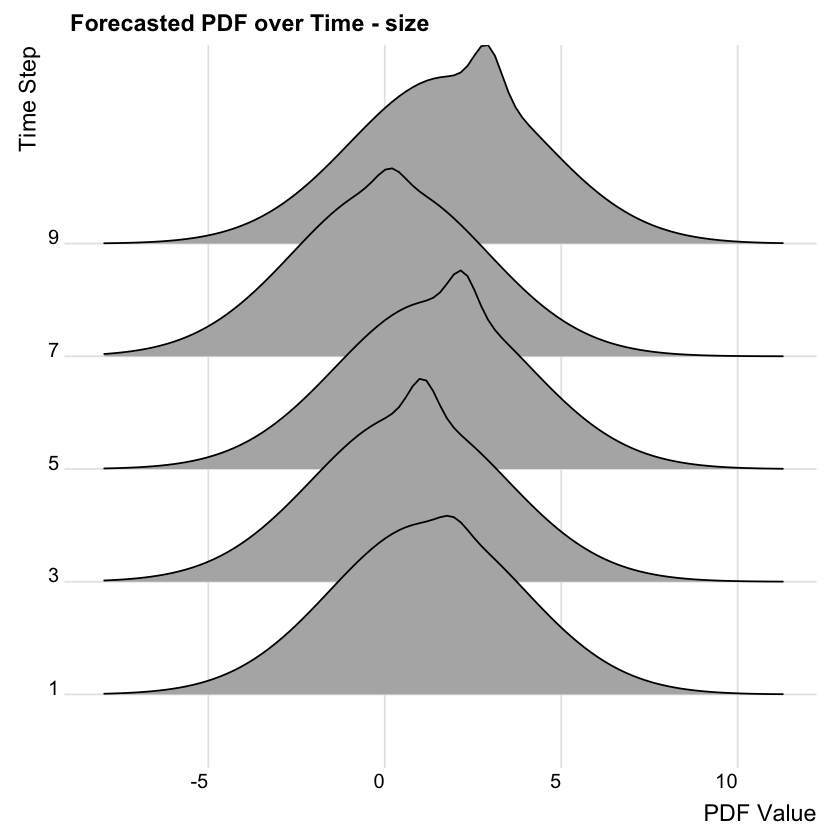

In [14]:
n_steps <- nrow(forecasts)
plot_steps <- seq(1, n_steps, by = 2)

for (dimension in emission_vars) {
  # Prepare data for ridge plot
  ridge_data <- data.frame(
    x = rep(
      attr(forecasts, paste0(dimension, "_x_vals")),
      times = length(plot_steps)
    ),
    y = as.vector(attr(forecasts, paste0(dimension, "_pdfs"))[ , plot_steps]),
    time = factor(rep(plot_steps, each = length(attr(forecasts, paste0(dimension, "_x_vals")))))
  )
    
  print(ggplot(ridge_data, aes(x = x, y = time, height = y, group = time)) +
    geom_density_ridges(stat = "identity", position = "identity") +
    labs(x = "PDF Value", y = "Time Step", title = paste("Forecasted PDF over Time -", dimension)) +
    theme_ridges() + 
    theme(axis.text.x = element_text(angle = 0, hjust = 1)))
}


## Validate

Create 1000 simulations of the true model using the ending state and the same covariates used in forecasting.

In [16]:
n_dimensions <- length(emission_vars)
n_simulations <- 1000
n_steps <- nrow(forecasts)

# Get last hidden state
true_last_state <- tail(attr(true_mod$obs()$data(), "state"), 1) # last state
# get TPM of last observation
last_tpm <- true_mod$hid()$tpm(nrow(true_mod$obs()$data()))[, , 1]

# Update delta0 to use distribution of first forecasted state
# TODO: Allow for first distribution to be stationary or custom
true_mod$hid()$update_delta0(last_tpm[true_last_state, ])

# Initialize a named list of 2D arrays to store the simulation results
simulated_data <- list()
for (dimension in emission_vars) {
  simulated_data[[dimension]] <- array(NA, dim = c(n_simulations, n_steps))
}

# Simulate data and store it in the array
for (i in 1:n_simulations) {
  sim <- true_mod$simulate(n = n_steps, data = forecasts, silent = TRUE)

  for (dimension in emission_vars) {
    # Get the simulated data for the current dimension
    simulated_data[[dimension]][i, ] <- sim[[dimension]]
  }
}

# Optionally, print a subset of the simulated data
print(simulated_data[[1]][1:5, ]) # Print the first 5 simulations


     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
[1,]    2    4    2   15    3    1    8    1    1     2
[2,]    2    1    0    9    3    1    4    4    4     5
[3,]    4    2    0   10    3    0    5    5    4     3
[4,]    1    1    2   11    2    1    6    2    4     7
[5,]    0    1    1    9    2    0    8    1    5     3


In [17]:
# Convert simulated data to a histogram at each time step
n_dimensions <- length(emission_vars)
n_steps <- nrow(forecasts)

# Initialize a array to store histograms for each time step
simulated_pdfs <- list()

# Define bin width
bin_width <- x_vals[2] - x_vals[1]

# Define bin edges such that the x_vals are centered in the bins
bin_edges <- c(x_vals - bin_width / 2, max(x_vals) + bin_width / 2)

# loop through each dimension and time step 
for (dimension in emission_vars) {

  # Get locations to create histogram bins
  x_vals <- attr(forecasts, paste0(dimension, "_x_vals"))

  # Initialize a array to store histograms for each time step
  simulated_pdfs[[dimension]] <- array(NA, dim = c(length(x_vals), n_steps))

  # Define bin width
  bin_width <- x_vals[2] - x_vals[1]

  # Define bin edges such that the x_vals are centered in the bins
  bin_edges <- c(x_vals - bin_width / 2, max(x_vals) + bin_width / 2)

  for (t in 1:n_steps) {
    # Filter simulated data to be within the range of bin edges
    filtered_data <- simulated_data[[dimension]][, t]
    filtered_data <- filtered_data[
      filtered_data >= min(bin_edges) & filtered_data <= max(bin_edges)
    ]

    # Create histogram with specified bin edges
    hist_obj <- hist(filtered_data, plot = FALSE, breaks = bin_edges)

    hist_obj$density <- hist_obj$counts / sum(hist_obj$counts)

    simulated_pdfs[[dimension]][, t] <- hist_obj$density
  }

}

simulated_pdfs[[1]][1:5, 1:5]

0.149,0.278,0.137,0.000,0.067
0.296,0.374,0.254,0.000,0.167
0.277,0.212,0.296,0.000,0.234
0.167,0.096,0.161,0.008,0.241
0.074,0.028,0.086,0.014,0.157


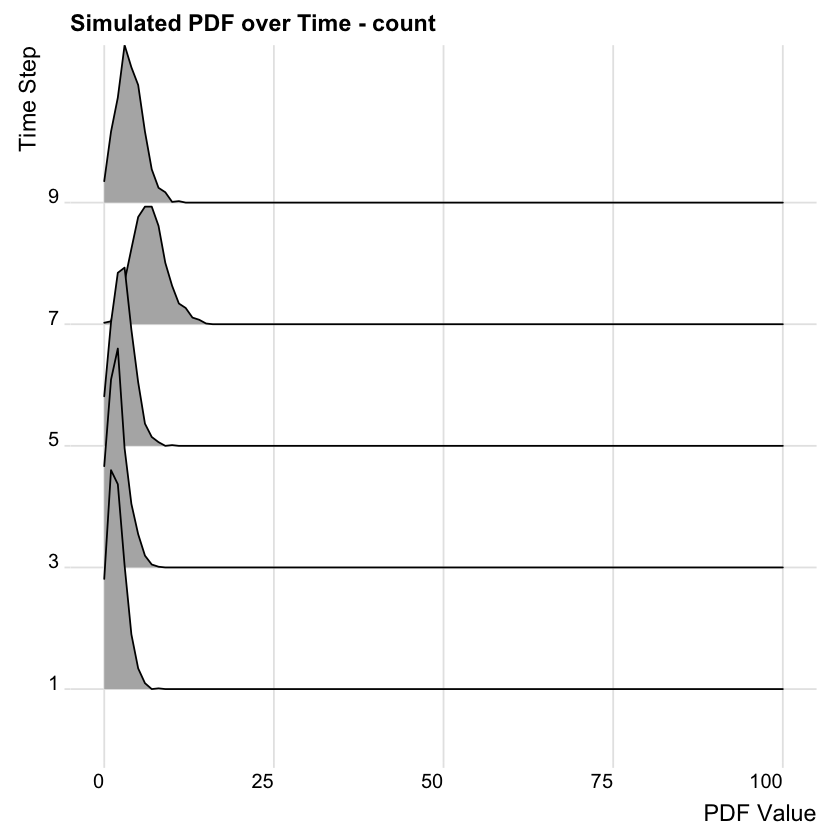

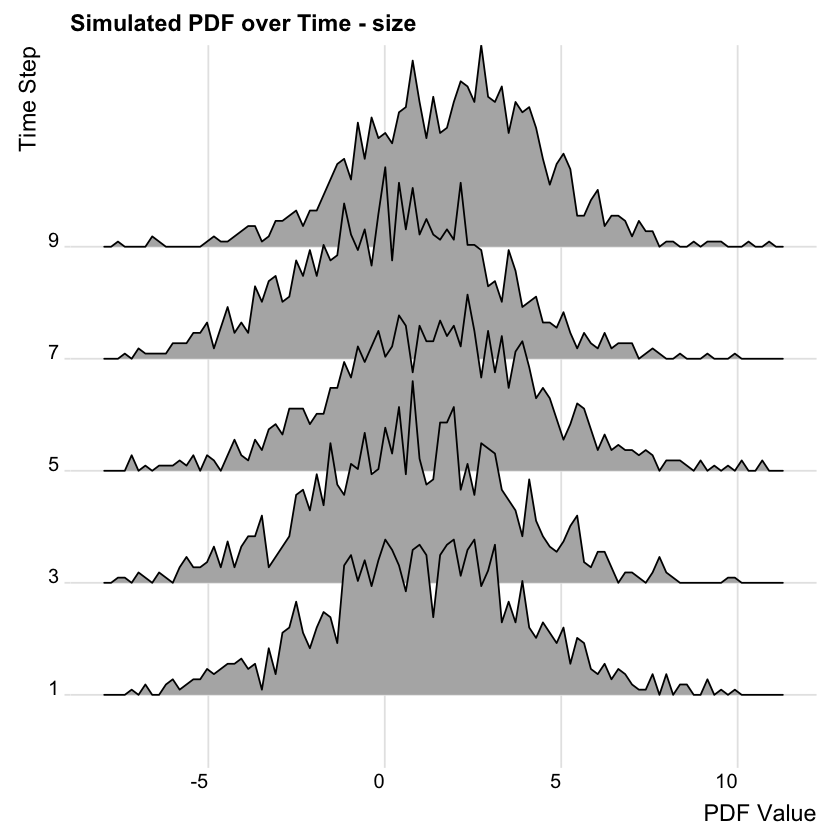

In [18]:

n_steps <- nrow(forecasts)
plot_steps <- seq(1, n_steps, by = 2)

for (dimension in emission_vars) {
  # Prepare data for ridge plot
  ridge_data <- data.frame(
    x = rep(
      attr(forecasts, paste0(dimension, "_x_vals")),
      times = length(plot_steps)
    ),
    y = as.vector(simulated_pdfs[[dimension]][, plot_steps]),
    time = factor(rep(plot_steps, each = length(attr(forecasts, paste0(dimension, "_x_vals")))))
  )
    
  print(ggplot(ridge_data, aes(x = x, y = time, height = y, group = time)) +
    geom_density_ridges(stat = "identity", position = "identity") +
    labs(x = "PDF Value", y = "Time Step", title = paste("Simulated PDF over Time -", dimension)) +
    theme_ridges() + 
    theme(axis.text.x = element_text(angle = 0, hjust = 1)))
}

#### Compare forecasted PDFs with simulated PDFs

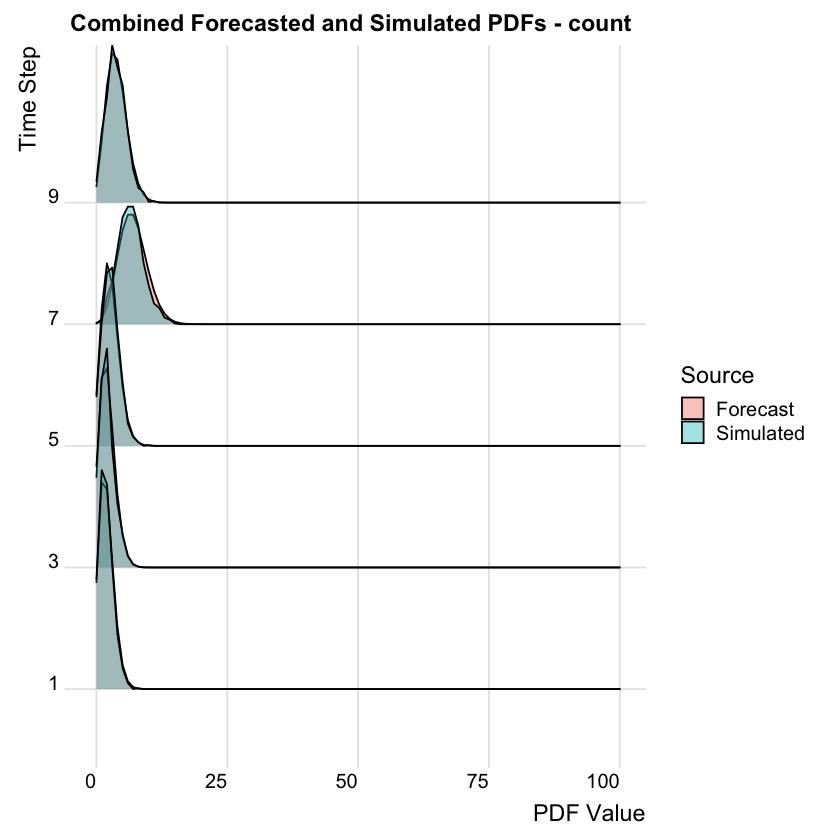

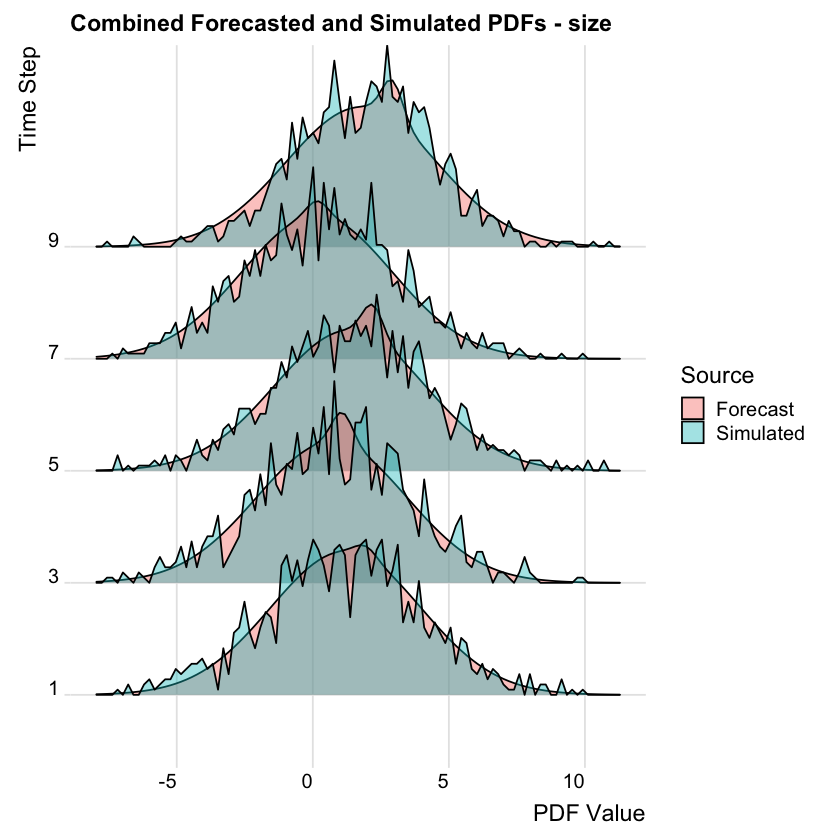

In [19]:
# Define the number of steps and the dimension to plot
n_steps <- nrow(forecasts)
plot_steps <- seq(1, n_steps, by = 2)  # Plot every second step for clarity

for (dimension in emission_vars) {
  # Get forecasted PDFs and simulated PDFs
  x_vals <- attr(forecasts, paste0(dimension, "_x_vals"))
  forecast_pdfs <- attr(forecasts, paste0(dimension, "_pdfs"))
  simulated_pdfs_dim <- simulated_pdfs[[dimension]]

  # Prepare data for ridge plot
  ridge_data <- data.frame(
    x = rep(x_vals, times = length(plot_steps) * 2),
    y = c(
      as.vector(forecast_pdfs[, plot_steps]),
      as.vector(simulated_pdfs_dim[, plot_steps])
    ),
    time = factor(rep(plot_steps, each = length(x_vals))),
    source = rep(c("Forecast", "Simulated"), each = length(x_vals) * length(plot_steps))
  )

  # Create the ridge plot
  print(
    ggplot(ridge_data, aes(x = x, y = time, height = y, group = interaction(time, source), fill = source)) +
      geom_density_ridges(stat = "identity", position = "identity", alpha = 0.4) +
      labs(
        x = "PDF Value",
        y = "Time Step",
        title = paste("Combined Forecasted and Simulated PDFs -", dimension),
        fill = "Source"
      ) +
      theme_ridges() +
      theme(axis.text.x = element_text(angle = 0, hjust = 1))
  )
}

### Appendix:
I originally had the idea of making the code more general, so instead of requiring the user to input the values of where evaluate the forecast PDF (i.e x_vals), it would instead return a PDF function for each forecasted time step, allowing the user to set arbitrary forecast precision. However I wasn't able to get the functions to work since the iterated varables (d, n) were always globally scoped so the PDFs never behaved properly. However I still think its a good method that I might try to revisit.

In [20]:
create_pdf_forecasts <- function(obs_dists, obs_par_forecast, hidden_state_forecast) {
  # Extract dimensions
  dimensions <- length(obs_dists)              # Number of observation dimensions
  states <- dim(obs_par_forecast)[2]       # Number of hidden states
  n_steps <- dim(obs_par_forecast)[3]       # Number of time steps
  
  # Extract PDF functions and parameter names from distribution objects
  pdfs <- lapply(obs_dists, function(dist) dist$pdf())
  
  # Initialize output: list of length dimensions, each containing a list of length n_steps
  output <- vector("list", dimensions)
  
  # Loop over each observation dimension
  for (d in seq_len(dimensions)) {
    output[[d]] <- vector("list", n_steps)
    # Loop over each time step
    for (n in seq_len(n_steps)) {
      # Use local() to create a new environment for each iteration
      local({
        d_val <- d
        n_val <- n
        output[[d_val]][[n_val]] <- function(x) {
          pdf_matrix <- sapply(seq_len(states), function(s) {
            do.call(pdfs[[d_val]], c(list(x = x), as.list(obs_par_forecast[d_val, s, n_val])))
          })
          as.vector(pdf_matrix %*% hidden_state_forecast[1, , n_val])
        }
      })
    }
  }

  return(output)
}

pdf_forecasts <- create_pdf_forecasts(obs_dists, obs_par_forecast, hidden_state_forecast)

ERROR: Error in dist$pdf: object of type 'closure' is not subsettable
